In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from data import *

%matplotlib widget

In [2]:
def decode_particle_id(data):
    """Decode particle_id into vertex id, generation, etc.
    """
    components = [
        ('vertex_id',    0xfff0000000000000, 13 * 4),
        ('primary_id',   0x000ffff000000000, 9 * 4),
        ('generation',   0x0000000fff000000, 6 * 4),
        ('secondary_id', 0x0000000000fff000, 3 * 4),
        ('process',      0x0000000000000fff, 0),
    ]
    pid = data['particle_id'].values.astype('u8')
    for name, mask, shift in components:
        data[name] = (pid & mask) >> shift
    return data

In [3]:
def count_particle_layer(merged_df):
    layer_id_list =  list(set(merged_df['layer_id']))
    particle_by_layer = dict()
    for l in layer_id_list:
        d =  merged_df[merged_df['layer_id']==l]
        particle_by_layer[l] =  list(set(d['particle_id']))
    return particle_by_layer

In [4]:
def load_hits(df):
    list_df = [row.tolist() for index, row in df.iterrows()]
    volumes = dict()
    
    for i in list_df:
        hit = Hit(
                  hit_id=i[0],
                  x=i[1],
                  y=i[2],
                  z=i[3],
                  volume_id=i[4],
                  layer_id =i[5],
                  module_id = i[6],
                  particle_id = i[7]
                  )
        volume_id = int(hit.volume_id)
        if volume_id not in volumes:
            volumes[volume_id] = [hit]
        else:
            volumes[volume_id] += [hit]
    for id, hits in volumes.items():
        layers = dict()
        for hit in hits:
            layer_id = int(hit.layer_id)
            if layer_id not in layers:
                layers[layer_id] = [hit]
            else:
                layers[layer_id] += [hit]
        volumes[id] = layers
    return volumes

In [5]:
def create_source_sink(hits):
    layers = sorted(list(hits.keys()))
    first_layer = hits[layers[0]]
    last_layer = hits[layers[-1]]

    source = Hit(
        hit_id=10,
        x=sum([h.x for h in first_layer]) / len(first_layer),
        y=sum([h.y for h in first_layer]) / len(first_layer),
        z=sum([h.z for h in first_layer]) / len(first_layer) - 200,
        volume_id=0,
        layer_id=0,
        module_id=0
    )

    sink = Hit(
        hit_id=10,
        x=sum([h.x for h in last_layer]) / len(last_layer),
        y=sum([h.y for h in last_layer]) / len(last_layer),
        z=sum([h.z for h in last_layer]) / len(last_layer) + 200,
        volume_id=0,
        layer_id=0,
        module_id=0
    )

    return source, sink


In [6]:
def display(hits, segments, source, sink):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    layers = list(hits.keys())
    xs = []
    ys = []
    zs = []

    for p in layers:
        h_p = hits[p]
        for h in h_p:
            xs.append(h.x)
            ys.append(h.y)
            zs.append(h.z)
    for h in [source, sink]:
        xs.append(h.x)
        ys.append(h.y)
        zs.append(h.z)
    ax.scatter(xs, ys, zs, marker='o', color='red')
    
    for track, hits in segments.items():
        if len(hits) > 3:
            hits = [source] + hits + [sink]
        
        for i in range(len(hits)-1):
            h1 = hits[i]
            h2 = hits[i+1]
            # if i==1:
            #     ax.plot(xs=[source.x, h1.x], ys=[source.y, h1.y], zs=[source.z, h1.z], color='green')
            # if i==len(hits)-2:
            #     ax.plot(xs=[sink.x, h2.x], ys=[sink.y, h2.y], zs=[sink.z, h2.z], color='black')

            
            ax.plot(xs=[h1.x, h2.x], ys=[h1.y, h2.y], zs=[h1.z, h2.z], color='blue')
            
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

In [7]:
def distance(h1, h2):
    distance = math.sqrt((h2.x - h1.x) ** 2 + (h2.y - h1.y) ** 2 + (h2.z - h1.z) ** 2)
    return distance

In [253]:
# read all truth particle
truth_hits_wo_noise = pd.read_csv("event000001000/event000001000-truth-wo-noise.csv")
truth_hits_wo_noise = decode_particle_id(truth_hits_wo_noise)
truth_hits_wo_noise

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,vertex_id,primary_id,generation,secondary_id,process
0,2,22525763437723648,-55.3385,0.630805,-1502.5,-0.570605,0.028390,-15.492200,0.000010,5,113,0,0,0
1,4,297237712845406208,-96.1229,-8.230360,-1502.5,-0.225235,-0.050968,-3.702320,0.000008,66,2,0,0,0
2,5,418835796137607168,-62.6594,-9.375040,-1502.5,-0.281806,-0.023487,-6.573180,0.000009,93,15,0,0,0
3,6,108087696726949888,-57.0856,-8.189710,-1502.5,-0.401129,-0.035276,-10.466900,0.000008,24,19,0,0,0
4,7,968286151951515648,-73.8608,-2.575860,-1502.5,-0.442662,-0.036969,-9.130100,0.000007,215,178,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103300,120935,445864815605317632,-763.3840,51.545000,2944.5,-1.640200,0.208933,6.293810,0.000018,99,123,0,0,0
103301,120936,900720956266250240,-804.6650,3.186900,2944.5,-0.315684,-0.094259,1.328200,0.000007,200,15,0,0,0
103302,120937,238705348779704320,-986.9890,41.731300,2952.5,-0.212508,0.095667,0.731932,0.000009,53,212,0,0,0
103303,120938,373800349619716096,-947.0050,18.765000,2952.5,-0.165762,-0.103945,0.800783,0.000007,83,23,0,0,0


In [161]:
# dataset = pd.read_csv('event000001000/event000001000-hits.csv')
# for v_id in set(dataset['volume_id']):
#     volume_id = dataset[dataset['volume_id']==v_id]
#     volume_path_out = 'event000001000/volume_id_'+ str(v_id) +".csv"
    # volume_id.to_csv(volume_path_out, index=False) 

In [162]:
# get hits from second sublayer in volume 9
v_id = 7
volume = pd.read_csv("event000001000/volume_id_"+str(v_id)+".csv")
volume

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.4099,-7.163700,-1502.5,7,2,1
1,2,-55.3361,0.635342,-1502.5,7,2,1
2,3,-83.8305,-1.143010,-1502.5,7,2,1
3,4,-96.1091,-8.241030,-1502.5,7,2,1
4,5,-62.6736,-9.371200,-1502.5,7,2,1
...,...,...,...,...,...,...,...
16868,16869,-130.6530,12.622500,-598.0,7,14,108
16869,16870,-114.4180,-2.393350,-598.0,7,14,108
16870,16871,-162.1100,12.024600,-598.0,7,14,108
16871,16872,-116.5970,-0.490688,-598.0,7,14,108


In [163]:
particles_in_volumn = truth_hits_wo_noise[truth_hits_wo_noise['hit_id'].isin(volume['hit_id'])]
particle_id = list(set(particles_in_volumn['particle_id']))
len(particle_id)

2086

In [167]:
merged_df = volume.merge(particles_in_volumn[['hit_id', 'particle_id']], on='hit_id', how='left').dropna()
particle_by_layer = count_particle_layer(merged_df)
for k, v in particle_by_layer.items():
    print(k, len(v))

2 979
4 1141
6 1319
8 1473
10 1625
12 1672
14 1697


In [168]:
same_particles = list()
last_layer = particle_by_layer[14]
layer_ids = list(particle_by_layer.keys())
for p in last_layer:
    state = True
    for layer_id in layer_ids[:-1]:
        if p not in particle_by_layer[layer_id]:
            state = False
    if state:
        same_particles.append(p)
print(len(same_particles))

634


In [194]:
N = 200

In [188]:
tmp_df_final = merged_df[merged_df['particle_id'].isin(same_particles[:N])]
data = []
for p in set(tmp_df_final['layer_id']):
    hp = tmp_df_final[tmp_df_final['layer_id']==p].drop_duplicates(subset=['particle_id'])
    data.append(hp)
df_final = pd.concat(data)
selected_particle_by_layer = count_particle_layer(df_final)
for k, v in selected_particle_by_layer.items():
    print(k, len(v))

2 600
4 600
6 600
8 600
10 600
12 600
14 600


In [195]:
path_out = "/Users/doduydao/daodd/PycharmProjects/track/src/data_selected/"+str(N)+"hits/known_track/hits.csv"

In [190]:
df_final.to_csv(path_out,index=False)

In [8]:
N = 50
v_id = 9

In [9]:
path_out = "/Users/doduydao/daodd/PycharmProjects/track/src/data_selected/"+str(N)+"hits/known_track/hits.csv"

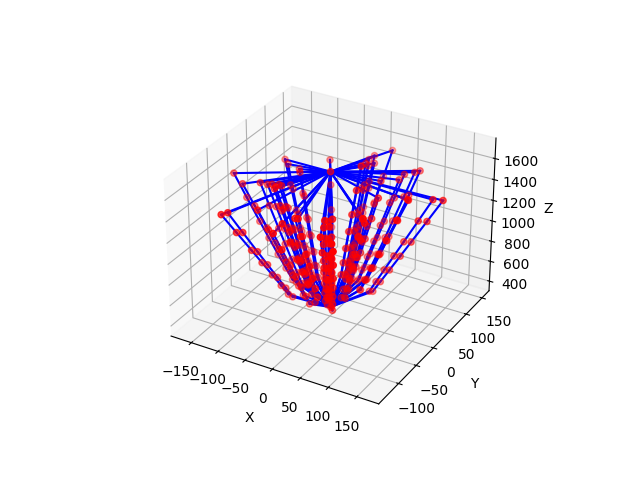

In [10]:
data_wrote = pd.read_csv(path_out)
hits = load_hits(data_wrote)[v_id]
source, sink = create_source_sink(hits)
track = dict()
for l, hp in hits.items():
    for i in range(len(hp)):
        id = hp[i].hit_id
        particle_id = hp[i].particle_id
        if particle_id not in track:
            track[particle_id] = [hp[i]]
        else:
            track[particle_id] += [hp[i]]
for t, h in track.items():
    h = sorted(h, key=lambda obj: obj.z)
    track[t] = h

# hits = load_hits(data_wrote)[9]
display(hits, track, source, sink)

In [270]:
cost = 0
count = 1
for pa, hs in track.items():
    # if len(hs) > 5:
    #     hs = [source] + hs + [sink]
    t = []
    ct = 0
    for i in range(len(hs)-2):
        h_i = hs[i]
        h_j = hs[i+1]
        h_k = hs[i+2]
        seg_1 = Segment(h_j, h_i)
        seg_2 = Segment(h_j, h_k)
        angle = Angle(seg_1=seg_1, seg_2=seg_2).angle
        dist = distance(h_i, h_j)//100 + distance(h_j, h_k)//100
        beta = angle * dist
        ct += beta
    print("track ", count, ":", ct)
    count+=1
    cost += ct
print('cost of all track is', cost)

track  1 : 0.007042933579070709
track  2 : 0.035645943842434136
track  3 : 0.027767997086675766
track  4 : 0.006730231684047183
track  5 : 0.031056282023955717
track  6 : 0.01204173439337941
track  7 : 0
track  8 : 0
track  9 : 0
track  10 : 0
track  11 : 0
track  12 : 0
track  13 : 0
track  14 : 0
track  15 : 0
track  16 : 0
cost of all track is 0.12028512260956292
